In [2]:
import sys
import math
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath2")
import matplotlib
import matplotlib as mpl
matplotlib.rcParams['figure.facecolor'] = '1'
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display
import multiprocessing

/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.2.
  .format(latest=latest, current=current), category=UserWarning)


In [3]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list, tAB_interval=None):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    if tAB_interval is not None:
        ax1.set_ylim(tAB_interval[0],tAB_interval[1])
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

def rmsd_of_cluster(cluster, rmsd, dtraj):
    rmsd_list=[]
    for i,element in enumerate(rmsd):
        if dtraj[i] in cluster:
            rmsd_list.append(element)
    length = len(rmsd_list)
    
    if length == 0:
        return None

    return sum(rmsd_list)/length



color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']
color_sequence+=color_sequence


def cdf(pmf):
    mycdf=[]
    tot = 0
    for element in pmf:
        tot+= element
        mycdf.append(tot)
    return np.array(mycdf)



def confindence_interval_cdf(populations, totCounts, conf_interval=0.95, n_samples=100000):
    counts = np.round(np.array(populations)*totCounts)
    partialCounts = sum(counts)
    myarray = list(counts)+[totCounts-partialCounts]
    s=np.random.dirichlet(myarray,n_samples)

    s_cdf = []

    for line in s:
        s_cdf.append(cdf(line))
    s_cdf = np.array(s_cdf)

    s = np.transpose(s)
    s_cdf = np.transpose(s_cdf)

    minval = []
    maxval = []
    minvalcdf = []
    maxvalcdf = []

    for line in s:
        sorted_line = np.sort(line)
        minval.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxval.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])

    for line in s_cdf:
        sorted_line = np.sort(line)
        minvalcdf.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxvalcdf.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])
    
    return minvalcdf[:-1], maxvalcdf[:-1]

In [8]:
dtrajs=np.load("../vamp_scoring/automatic_eigenvalue/ntl9/dtrajs_ntl9_lag10ns.npy", allow_pickle=True)

In [9]:
msm1 = pyemma.msm.estimate_markov_model(list(dtrajs), lag=1, dt_traj='0.0002 us')

In [10]:
range_per_lag = [[200,7000]]

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 61.72ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 67.20ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 94.40ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 121.60ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 148.80ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 176.00ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 203.20ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 230.40ns, t_min: 239.98ns, t_max: 1.53e+04ns, tAB: 0.00ns
t_cut: 257.60ns, t_min: 275.20ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 284.80ns, t_min: 299.25ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 312.00ns, t_min: 316.25ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 339.20ns, t_min: 366.10ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 366.40ns, t_min: 377.25ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 393.60ns, t_min: 407.64ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 420.80ns, t_min: 425.83ns, t_max: 1.53e+04ns, tAB: 3100.06ns
t_cut: 4

#### t_AB plots:

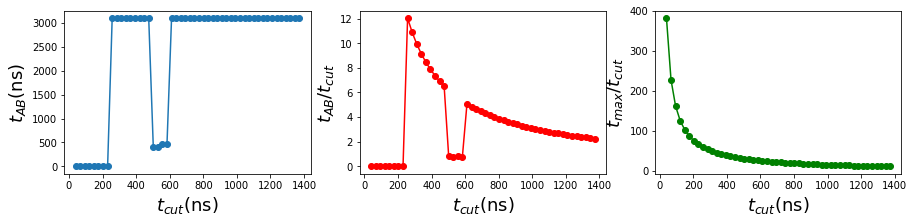

In [11]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//50
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    
    clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

In [7]:
(np.array(t_AB_list)*0.2)[8:17]

array([3100.05874322, 3100.05874322, 3100.05874322, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326])

In [8]:
(np.array(t_AB_list)*0.2)[21:]

array([3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326, 3100.05874326, 3100.05874326, 3100.05874326,
       3100.05874326])

In [9]:
interm_lengths = []

for i in range(8,17):

    pick = i

    #Selection of the t_cut
    macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
    # Folded and unfolded definition
    stateA = big_clusters_list[pick][macrostates[0]]
    stateB = big_clusters_list[pick][macrostates[1]]
    
    interm_lengths.append(100 - (len(stateA)+len(stateB)))

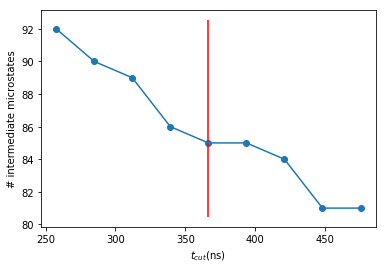

In [10]:
plt.figure()
plt.scatter(np.array(t_cut_values)[8:17]*0.2, interm_lengths)
plt.plot(np.array(t_cut_values)[8:17]*0.2, interm_lengths)
plt.xlabel("$t_{cut}\mathrm{(ns)}$")
plt.ylabel('# intermediate microstates')
plt.vlines((np.array(t_cut_values)*0.2)[12], plt.ylim()[0], plt.ylim()[1], color='r')
plt.show()

In [11]:
interm_lengths = []

for i in range(21,50):

    pick = i

    #Selection of the t_cut
    macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
    # Folded and unfolded definition
    stateA = big_clusters_list[pick][macrostates[0]]
    stateB = big_clusters_list[pick][macrostates[1]]
    
    interm_lengths.append(100 - (len(stateA)+len(stateB)))

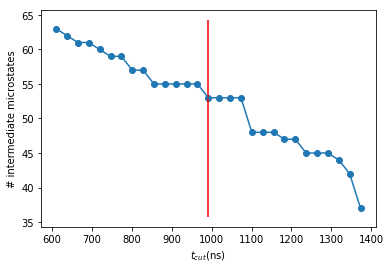

In [12]:
plt.figure()
plt.scatter(np.array(t_cut_values)[21:50]*0.2, interm_lengths)
plt.plot(np.array(t_cut_values)[21:50]*0.2, interm_lengths)
plt.xlabel("$t_{cut}\mathrm{(ns)}$")
plt.ylabel('# intermediate microstates')
plt.vlines((np.array(t_cut_values)*0.2)[35], plt.ylim()[0], plt.ylim()[1], color='r')
plt.show()

In [13]:
# do the two plateau middles

In [14]:
# MIDDLE PLATEAU 1

In [12]:
(np.array(t_cut_values)*0.2)[12]

366.40000000000003

In [13]:
pick = 12

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [14]:
print(stateA)

[1, 34, 66, 73, 54, 27, 48, 50, 98]


In [15]:
len(stateA)

9

In [16]:
print(stateB)

[0, 36, 77, 18, 10, 46]


In [17]:
len(stateB)

6

In [18]:
100 - (len(stateA)+len(stateB))

85

In [19]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

In [20]:
dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [340]:
def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

In [25]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 15/12


NameError: name 'nm_model_hist10ns_kinetics' is not defined

In [26]:
# forgot to uncomment that line above, repeated here

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 15/12
Number of A->B/B->A  events: 14/11
Number of A->B/B->A  events: 14/11
Number of A->B/B->A  events: 13/10
Number of A->B/B->A  events: 12/9
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 10/7
Number of A->B/B->A  events: 9/6
Number of A->B/B->A  events: 6/3


In [27]:
np.save('ntl9_empirical_mfptsAB_agglomerative_cluster_middleplateau1', empirical_mfptsAB)
np.save('ntl9_empirical_mfptsBA_agglomerative_cluster_middleplateau1', empirical_mfptsBA)
np.save('ntl9_std_errAB_agglomerative_cluster_middleplateau1', std_errAB)
np.save('ntl9_std_errBA_agglomerative_cluster_middleplateau1', std_errBA)
np.save('ntl9_nm_mfptsAB_agglomerative_cluster_middleplateau1', nm_mfptsAB)
np.save('ntl9_nm_mfptsBA_agglomerative_cluster_middleplateau1', nm_mfptsBA)
np.save('ntl9_nm_hist10ns_mfptsAB_agglomerative_cluster_middleplateau1', nm_hist10ns_mfptsAB)
np.save('ntl9_nm_hist10ns_mfptsBA_agglomerative_cluster_middleplateau1', nm_hist10ns_mfptsBA)
np.save('ntl9_nm_hist100ns_mfptsAB_agglomerative_cluster_middleplateau1', nm_hist100ns_mfptsAB)
np.save('ntl9_nm_hist100ns_mfptsBA_agglomerative_cluster_middleplateau1', nm_hist100ns_mfptsBA)

In [5]:
empirical_mfptsAB = np.load('ntl9_empirical_mfptsAB_agglomerative_cluster_middleplateau1.npy') 
empirical_mfptsBA = np.load('ntl9_empirical_mfptsBA_agglomerative_cluster_middleplateau1.npy')
std_errAB = np.load('ntl9_std_errAB_agglomerative_cluster_middleplateau1.npy')
std_errBA = np.load('ntl9_std_errBA_agglomerative_cluster_middleplateau1.npy')
nm_mfptsAB = np.load('ntl9_nm_mfptsAB_agglomerative_cluster_middleplateau1.npy')
nm_mfptsBA = np.load('ntl9_nm_mfptsBA_agglomerative_cluster_middleplateau1.npy')
nm_hist10ns_mfptsAB = np.load('ntl9_nm_hist10ns_mfptsAB_agglomerative_cluster_middleplateau1.npy')
nm_hist10ns_mfptsBA = np.load('ntl9_nm_hist10ns_mfptsBA_agglomerative_cluster_middleplateau1.npy')
nm_hist100ns_mfptsAB = np.load('ntl9_nm_hist100ns_mfptsAB_agglomerative_cluster_middleplateau1.npy')
nm_hist100ns_mfptsBA = np.load('ntl9_nm_hist100ns_mfptsBA_agglomerative_cluster_middleplateau1.npy')

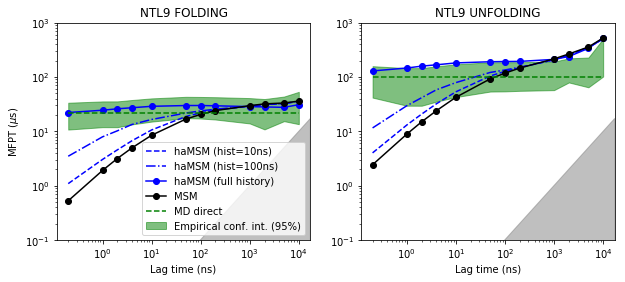

In [29]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e3)

plt.savefig('ntl9_mfpts_agglomerative_middleplateau1.png', dpi=300)
plt.savefig('ntl9_mfpts_agglomerative_middleplateau1.pdf')
plt.show()

In [30]:
# COMPARE TO 10-microstate-intermediate PCCA

In [345]:
empirical_mfptsAB2 = np.load('ntl9_empirical_mfptsAB.npy')
empirical_mfptsBA2 = np.load('ntl9_empirical_mfptsBA.npy')
std_errAB2 = np.load('ntl9_std_errAB.npy')
std_errBA2 = np.load('ntl9_std_errBA.npy')
nm_mfptsAB2 = np.load('ntl9_nm_mfptsAB.npy')
nm_mfptsBA2 = np.load('ntl9_nm_mfptsBA.npy')
nm_hist10ns_mfptsAB2 = np.load('ntl9_nm_hist10ns_mfptsAB.npy')
nm_hist10ns_mfptsBA2 = np.load('ntl9_nm_hist10ns_mfptsBA.npy')
nm_hist100ns_mfptsAB2 = np.load('ntl9_nm_hist100ns_mfptsAB.npy')
nm_hist100ns_mfptsBA2 = np.load('ntl9_nm_hist100ns_mfptsBA.npy')

dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/ntl9/dtrajs_ntl9_lag10ns.npy", allow_pickle=True)

# Unfolded
stateA=[1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 34, 35, 37, 40, 41, 42, 45, 47, 48, 49, 50, 51, 52, 54, 57, 58, 61, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 75, 76, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99]

# Folded
stateB=[0, 4, 10, 11, 18, 29, 33, 36, 43, 46, 55, 56, 60, 62, 67, 77, 78, 87, 91]

lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

lags2 = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 50000, 100000, 150000, 200000, 250000, 300000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags2]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_to_use2 = lags2

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use2 ]


msm_mfptAB2 = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use2))])
msm_mfptBA2 = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use2))])

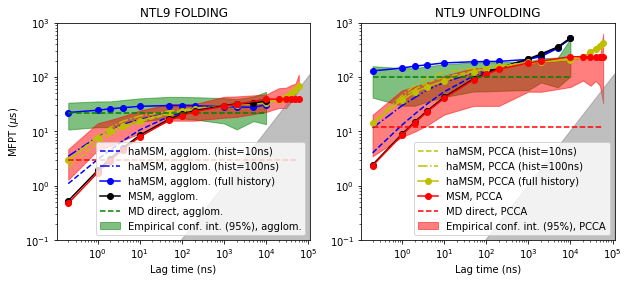

In [25]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_ns2 = np.array(lag_to_use2) * 0.2

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns2, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, agglom. (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, agglom. (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, agglom. (full history)", c='b')

ax1.plot(lag_to_use_ns2, nm_hist10ns_mfptsAB2, "--", c='y')
ax1.plot(lag_to_use_ns2, nm_hist100ns_mfptsAB2, "-.", c='y')
ax1.plot(lag_to_use_ns2, nm_mfptsAB2, "-o", c='y')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns2, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns2, [empirical_mfptsAB2[0] for i in lag_to_use_ns2], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns2, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns2, nm_hist10ns_mfptsBA2, "--", c='y', label="haMSM, PCCA (hist=10ns)")
ax2.plot(lag_to_use_ns2, nm_hist100ns_mfptsBA2, "-.", c='y', label="haMSM, PCCA (hist=100ns)")
ax2.plot(lag_to_use_ns2, nm_mfptsBA2, "-o", c='y', label="haMSM, PCCA (full history)")

ax2.plot(lag_to_use_ns2, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns2, [empirical_mfptsBA2[0] for i in lag_to_use_ns2], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')

plt.savefig('ntl9_mfpts_agglom_middleplateau1_PCCA_10micro_joint.png', dpi=300)
plt.savefig('ntl9_mfpts_agglom_middleplateau1_PCCA_10micro_joint.pdf')
plt.show()

In [46]:
# MIDDLE PLATEAU 2

In [27]:
(np.array(t_cut_values)*0.2)[35]

992.0

In [28]:
pick = 35

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [29]:
print(stateA)

[1, 34, 66, 73, 54, 27, 48, 50, 98, 61, 24, 96, 41, 3, 84, 17, 89, 94, 9, 86, 26, 2, 8, 15, 92, 75, 83, 47, 21, 90, 22, 31, 74, 40, 30, 63, 79]


In [30]:
len(stateA)

37

In [31]:
print(stateB)

[0, 36, 77, 18, 10, 46, 91, 4, 60, 55]


In [32]:
len(stateB)

10

In [33]:
100 - (len(stateA)+len(stateB))

53

In [34]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 50000, 100000, 150000, 200000, 250000, 300000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

In [35]:
dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [57]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_h==ist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 33/30
Number of A->B/B->A  events: 20/17
Number of A->B/B->A  events: 20/17
Number of A->B/B->A  events: 19/16
Number of A->B/B->A  events: 15/12
Number of A->B/B->A  events: 13/10
Number of A->B/B->A  events: 13/10
Number of A->B/B->A  events: 13/10
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 9/6
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 4/1


In [58]:
np.save('ntl9_empirical_mfptsAB_agglomerative_cluster_middleplateau2', empirical_mfptsAB)
np.save('ntl9_empirical_mfptsBA_agglomerative_cluster_middleplateau2', empirical_mfptsBA)
np.save('ntl9_std_errAB_agglomerative_cluster_middleplateau2', std_errAB)
np.save('ntl9_std_errBA_agglomerative_cluster_middleplateau2', std_errBA)
np.save('ntl9_nm_mfptsAB_agglomerative_cluster_middleplateau2', nm_mfptsAB)
np.save('ntl9_nm_mfptsBA_agglomerative_cluster_middleplateau2', nm_mfptsBA)
np.save('ntl9_nm_hist10ns_mfptsAB_agglomerative_cluster_middleplateau2', nm_hist10ns_mfptsAB)
np.save('ntl9_nm_hist10ns_mfptsBA_agglomerative_cluster_middleplateau2', nm_hist10ns_mfptsBA)
np.save('ntl9_nm_hist100ns_mfptsAB_agglomerative_cluster_middleplateau2', nm_hist100ns_mfptsAB)
np.save('ntl9_nm_hist100ns_mfptsBA_agglomerative_cluster_middleplateau2', nm_hist100ns_mfptsBA)

In [26]:
empirical_mfptsAB = np.load('ntl9_empirical_mfptsAB_agglomerative_cluster_middleplateau2.npy') 
empirical_mfptsBA = np.load('ntl9_empirical_mfptsBA_agglomerative_cluster_middleplateau2.npy')
std_errAB = np.load('ntl9_std_errAB_agglomerative_cluster_middleplateau2.npy')
std_errBA = np.load('ntl9_std_errBA_agglomerative_cluster_middleplateau2.npy')
nm_mfptsAB = np.load('ntl9_nm_mfptsAB_agglomerative_cluster_middleplateau2.npy')
nm_mfptsBA = np.load('ntl9_nm_mfptsBA_agglomerative_cluster_middleplateau2.npy')
nm_hist10ns_mfptsAB = np.load('ntl9_nm_hist10ns_mfptsAB_agglomerative_cluster_middleplateau2.npy')
nm_hist10ns_mfptsBA = np.load('ntl9_nm_hist10ns_mfptsBA_agglomerative_cluster_middleplateau2.npy')
nm_hist100ns_mfptsAB = np.load('ntl9_nm_hist100ns_mfptsAB_agglomerative_cluster_middleplateau2.npy')
nm_hist100ns_mfptsBA = np.load('ntl9_nm_hist100ns_mfptsBA_agglomerative_cluster_middleplateau2.npy')

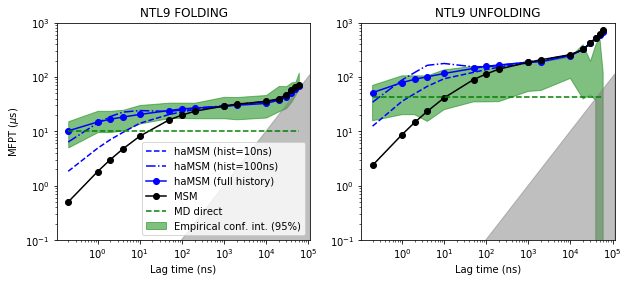

In [36]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e3)

plt.savefig('ntl9_mfpts_agglomerative_middleplateau2.png', dpi=300)
plt.savefig('ntl9_mfpts_agglomerative_middleplateau2.pdf')
plt.show()

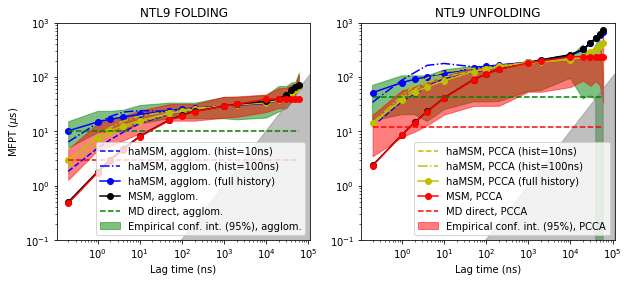

In [37]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_ns2 = np.array(lag_to_use2) * 0.2

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns2, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, agglom. (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, agglom. (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, agglom. (full history)", c='b')

ax1.plot(lag_to_use_ns2, nm_hist10ns_mfptsAB2, "--", c='y')
ax1.plot(lag_to_use_ns2, nm_hist100ns_mfptsAB2, "-.", c='y')
ax1.plot(lag_to_use_ns2, nm_mfptsAB2, "-o", c='y')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns2, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns2, [empirical_mfptsAB2[0] for i in lag_to_use_ns2], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns2, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns2, nm_hist10ns_mfptsBA2, "--", c='y', label="haMSM, PCCA (hist=10ns)")
ax2.plot(lag_to_use_ns2, nm_hist100ns_mfptsBA2, "-.", c='y', label="haMSM, PCCA (hist=100ns)")
ax2.plot(lag_to_use_ns2, nm_mfptsBA2, "-o", c='y', label="haMSM, PCCA (full history)")

ax2.plot(lag_to_use_ns2, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns2, [empirical_mfptsBA2[0] for i in lag_to_use_ns2], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')

plt.savefig('ntl9_mfpts_agglom_middleplateau2_PCCA_10micro_joint.png', dpi=300)
plt.savefig('ntl9_mfpts_agglom_middleplateau2_PCCA_10micro_joint.pdf')
plt.show()

In [ ]:
# END OF PLATEAU 2

In [330]:
(np.array(t_cut_values)*0.2)[49]

1372.8000000000002

In [331]:
pick = 49

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [332]:
print(stateA)

[1, 34, 66, 73, 54, 27, 48, 50, 98, 61, 24, 96, 41, 3, 84, 17, 89, 94, 9, 86, 26, 2, 8, 15, 92, 75, 83, 47, 21, 90, 22, 31, 74, 40, 30, 63, 79, 5, 19, 93, 68, 45, 82, 13, 14, 52, 95, 57, 69]


In [333]:
len(stateA)

49

In [334]:
print(stateB)

[0, 36, 77, 18, 10, 46, 91, 4, 60, 55, 29, 87, 33, 56]


In [335]:
len(stateB)

14

In [336]:
100 - (len(stateA)+len(stateB))

37

In [337]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 50000, 100000, 150000, 200000, 250000, 300000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

In [338]:
dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [341]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 37/34
Number of A->B/B->A  events: 23/20
Number of A->B/B->A  events: 22/19
Number of A->B/B->A  events: 20/17
Number of A->B/B->A  events: 16/13
Number of A->B/B->A  events: 14/11
Number of A->B/B->A  events: 14/11
Number of A->B/B->A  events: 14/11
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 11/8
Number of A->B/B->A  events: 10/7
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 7/4
Number of A->B/B->A  events: 4/1


In [342]:
np.save('ntl9_empirical_mfptsAB_agglomerative_cluster_endplateau2', empirical_mfptsAB)
np.save('ntl9_empirical_mfptsBA_agglomerative_cluster_endplateau2', empirical_mfptsBA)
np.save('ntl9_std_errAB_agglomerative_cluster_endplateau2', std_errAB)
np.save('ntl9_std_errBA_agglomerative_cluster_endplateau2', std_errBA)
np.save('ntl9_nm_mfptsAB_agglomerative_cluster_endplateau2', nm_mfptsAB)
np.save('ntl9_nm_mfptsBA_agglomerative_cluster_endplateau2', nm_mfptsBA)
np.save('ntl9_nm_hist10ns_mfptsAB_agglomerative_cluster_endplateau2', nm_hist10ns_mfptsAB)
np.save('ntl9_nm_hist10ns_mfptsBA_agglomerative_cluster_endplateau2', nm_hist10ns_mfptsBA)
np.save('ntl9_nm_hist100ns_mfptsAB_agglomerative_cluster_endplateau2', nm_hist100ns_mfptsAB)
np.save('ntl9_nm_hist100ns_mfptsBA_agglomerative_cluster_endplateau2', nm_hist100ns_mfptsBA)

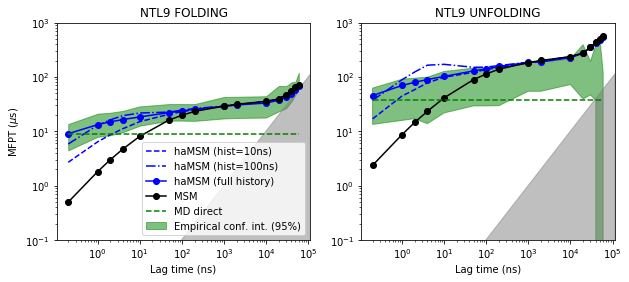

In [344]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e3)

plt.savefig('ntl9_mfpts_agglomerative_endplateau2.png', dpi=300)
plt.savefig('ntl9_mfpts_agglomerative_endplateau2.pdf')
plt.show()

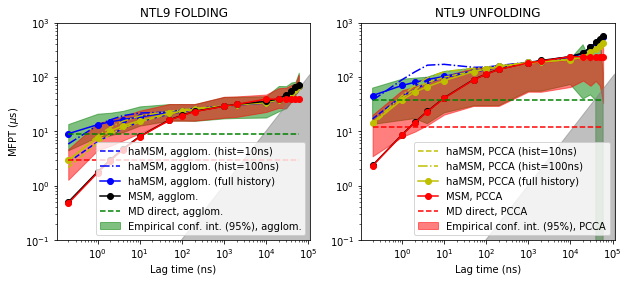

In [353]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_ns2 = np.array(lag_to_use2) * 0.2

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns2, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, agglom. (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, agglom. (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, agglom. (full history)", c='b')

ax1.plot(lag_to_use_ns2, nm_hist10ns_mfptsAB2, "--", c='y')
ax1.plot(lag_to_use_ns2, nm_hist100ns_mfptsAB2, "-.", c='y')
ax1.plot(lag_to_use_ns2, nm_mfptsAB2, "-o", c='y')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns2, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns2, [empirical_mfptsAB2[0] for i in lag_to_use_ns2], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns2, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns2, nm_hist10ns_mfptsBA2, "--", c='y', label="haMSM, PCCA (hist=10ns)")
ax2.plot(lag_to_use_ns2, nm_hist100ns_mfptsBA2, "-.", c='y', label="haMSM, PCCA (hist=100ns)")
ax2.plot(lag_to_use_ns2, nm_mfptsBA2, "-o", c='y', label="haMSM, PCCA (full history)")

ax2.plot(lag_to_use_ns2, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns2, [empirical_mfptsBA2[0] for i in lag_to_use_ns2], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e3)
plt.legend(loc='lower right')

plt.savefig('ntl9_mfpts_agglom_endplateau2_PCCA_10micro_joint.png', dpi=300)
plt.savefig('ntl9_mfpts_agglom_endplateau2_PCCA_10micro_joint.pdf')
plt.show()

In [350]:
lag_to_use

array([    1,     5,    10,    20,    50,   250,   500,  1000,  5000,
       10000, 25000, 50000])

In [38]:
# SENSITIVITY OF MSMs to PCCA cutoff

In [39]:
chignolin_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/chignolin_lag150ns_metastable_memberships.npy')

villin_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_lag100ns_metastable_memberships_3states.npy')
villin_misfold = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_misfold.npy')

trpcage_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/trpcage_lag100ns_metastable_memberships.npy')

ntl9_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/ntl9_lag200ns_metastable_memberships.npy')

In [40]:
# returns [[folded], [unfolded], [intermediate]]
def get_sets(cutoff):
    chignolin_sets = [np.concatenate(np.argwhere(chignolin_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(chignolin_membs[:,0] >= cutoff)), []]
    
    for i in range(100):
        if i not in chignolin_sets[0] and i not in chignolin_sets[1]:
            chignolin_sets[2].append(i)
    
    villin_sets = [np.concatenate(np.argwhere(villin_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(villin_membs[:,2] >= cutoff)), []]
    
    for i in range(100):
        if i not in villin_sets[0] and i not in villin_sets[1] and i not in villin_misfold:
            villin_sets[2].append(i)

    trpcage_sets = [np.concatenate(np.argwhere(trpcage_membs[:,0] >= cutoff)),
    np.concatenate(np.argwhere(trpcage_membs[:,1] >= cutoff)), []]
    
    for i in range(100):
        if i not in trpcage_sets[0] and i not in trpcage_sets[1]:
            trpcage_sets[2].append(i)

    ntl9_sets = [np.concatenate(np.argwhere(ntl9_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(ntl9_membs[:,0] >= cutoff)), []]
    
    for i in range(100):
        if i not in ntl9_sets[0] and i not in ntl9_sets[1]:
            ntl9_sets[2].append(i)
    
    return (chignolin_sets, villin_sets, trpcage_sets, ntl9_sets)

In [328]:
msm_mfptAB_s = []
msm_mfptBA_s = []
intermediate_lens = []

for i,cutoff in enumerate(([0.5, 0.6, 0.8, 0.9, 0.93, 0.935] + list(np.arange(0.94, 0.95, 0.001)) + list(np.arange(0.95, 0.98, 0.005)) + [0.992, 0.995, 0.999, 0.99995])):

    stateA = get_sets(cutoff)[3][1] # unfolded
    stateB = get_sets(cutoff)[3][0] # folded
    
    intermediate_lens.append(100 - (len(stateA)+len(stateB)))

    lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 50000, 100000, 150000, 200000, 250000, 300000])

    msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

    dt = 0.0002 # in micro-sec

    lag_to_use = lags

    lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

    msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
    msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

    msm_mfptAB_s.append(msm_mfptAB)
    msm_mfptBA_s.append(msm_mfptBA)
    
    print(i)

intermediate_lens = np.array(intermediate_lens)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


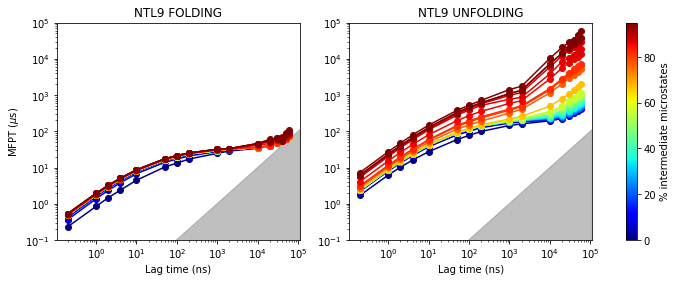

In [329]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

fig=plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)

#colors = plt.cm.jet(np.linspace(0,1,len(msm_mfptAB_s)))

norm = matplotlib.colors.Normalize(vmin=intermediate_lens.min(), vmax=intermediate_lens.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i,msm_mfptAB in enumerate(msm_mfptAB_s):
    ax1.plot(lag_to_use_ns, msm_mfptAB, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-1, 1e5)
#plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

for i,msm_mfptBA in enumerate(msm_mfptBA_s):
    ax2.plot(lag_to_use_ns, msm_mfptBA, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-1, 1e5)

cbar = fig.colorbar(cmap, ax=[ax1,ax2])
cbar.set_label('% intermediate microstates')

plt.savefig('ntl9_mfpts_pcca_msms.png', dpi=300)
plt.savefig('ntl9_mfpts_pcca_msms.pdf')
plt.show()